
=== Price Data Preview ===
Ticker           AAPL        MSFT         SPY
Date                                         
2020-01-02  72.468285  152.505646  297.698914
2020-01-03  71.763718  150.606720  295.444672
2020-01-06  72.335564  150.996017  296.571869
2020-01-07  71.995354  149.619263  295.738037
2020-01-08  73.153503  152.002457  297.314148

=== Return Summary (Daily) ===
            mean       std       min       max
Ticker                                        
AAPL    0.001187  0.021146 -0.128647  0.119808
MSFT    0.001095  0.020546 -0.147390  0.142169
SPY     0.000543  0.014254 -0.109424  0.090603


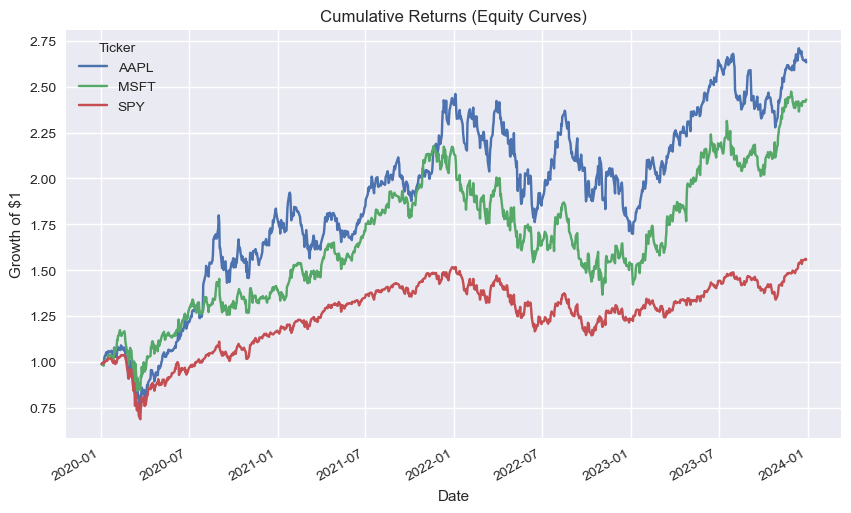


=== Annualized Volatility ===
Ticker
AAPL    0.335681
MSFT    0.326155
SPY     0.226270
dtype: float64

=== Maximum Drawdown (by asset) ===
Ticker
AAPL   -0.314273
MSFT   -0.371485
SPY    -0.337173
dtype: float64


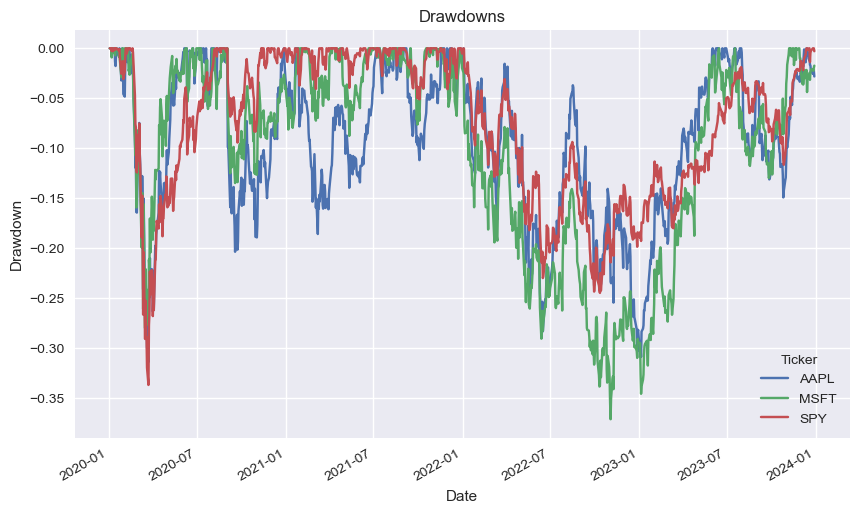


=== Risk Summary (Assets) ===
        Annualized Volatility  Maximum Drawdown
Ticker                                         
AAPL                 0.335681         -0.314273
MSFT                 0.326155         -0.371485
SPY                  0.226270         -0.337173


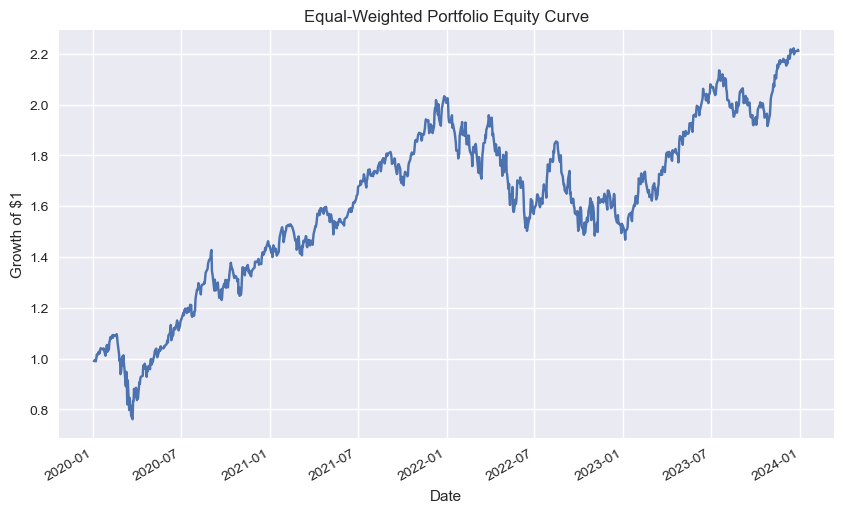


=== Portfolio Metrics ===
Annualized Volatility: 0.2761
Maximum Drawdown:     -0.3055


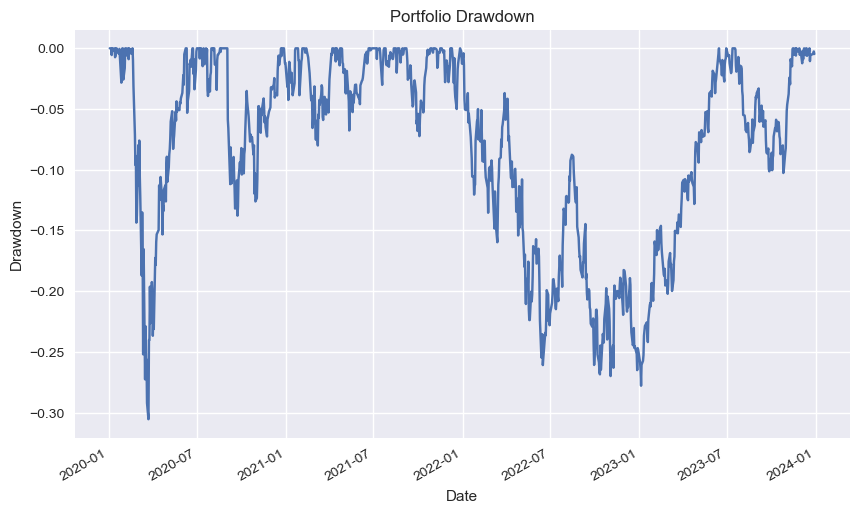


=== Portfolio Summary Table ===
   Portfolio Annualized Volatility  Portfolio Maximum Drawdown
0                          0.27612                     -0.3055

Done ✅


In [3]:
# ============================================================
# Market Data Analysis & PnL Modeling
# ============================================================
# This script:
# - Downloads equity price data (Yahoo Finance via yfinance)
# - Computes returns, PnL/equity curves, volatility, drawdowns
# - Builds an equal-weight portfolio
# - Produces plots + summary tables
# ============================================================

import sys
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0. Ensure yfinance is installed
# -----------------------------
try:
    import yfinance as yf
except ModuleNotFoundError:
    print("yfinance not found. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    import yfinance as yf

plt.style.use("seaborn-v0_8")


def download_prices(tickers, start_date, end_date):
    """
    Download adjusted close prices using yfinance.
    Returns a DataFrame indexed by date with columns=tickers.
    """
    df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False,
    )

    # When multiple tickers, columns are multi-index: ('Close', 'AAPL'), etc.
    # We want the Close prices only.
    if isinstance(df.columns, pd.MultiIndex):
        prices = df["Close"].copy()
    else:
        # Single ticker: df is single-level; "Close" is a column
        prices = df[["Close"]].copy()
        prices.columns = tickers

    # Drop rows where all tickers are missing
    prices = prices.dropna(how="all")
    return prices


def compute_drawdowns(equity_curve):
    """
    equity_curve: DataFrame (or Series) of cumulative growth of $1.
    Returns drawdown series/dataframe and max drawdown.
    """
    rolling_max = equity_curve.cummax()
    drawdown = equity_curve / rolling_max - 1.0
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown


def main():
    # -----------------------------
    # 1. User Inputs
    # -----------------------------
    tickers = ["AAPL", "MSFT", "SPY"]
    start_date = "2020-01-01"
    end_date = "2024-01-01"

    # -----------------------------
    # 2. Download Market Data
    # -----------------------------
    prices = download_prices(tickers, start_date, end_date)

    print("\n=== Price Data Preview ===")
    print(prices.head())

    # -----------------------------
    # 3. Compute Daily Returns
    # -----------------------------
    returns = prices.pct_change().dropna()

    print("\n=== Return Summary (Daily) ===")
    print(returns.describe().T[["mean", "std", "min", "max"]])

    # -----------------------------
    # 4. Equity Curves (Growth of $1)
    # -----------------------------
    equity_curve = (1.0 + returns).cumprod()

    ax = equity_curve.plot(figsize=(10, 6), title="Cumulative Returns (Equity Curves)")
    ax.set_ylabel("Growth of $1")
    plt.show()

    # -----------------------------
    # 5. Annualized Volatility
    # -----------------------------
    annualized_vol = returns.std() * np.sqrt(252)

    print("\n=== Annualized Volatility ===")
    print(annualized_vol)

    # -----------------------------
    # 6. Drawdowns + Max Drawdown
    # -----------------------------
    drawdown, max_drawdown = compute_drawdowns(equity_curve)

    print("\n=== Maximum Drawdown (by asset) ===")
    print(max_drawdown)

    ax = drawdown.plot(figsize=(10, 6), title="Drawdowns")
    ax.set_ylabel("Drawdown")
    plt.show()

    # -----------------------------
    # 7. Risk Summary Table (Assets)
    # -----------------------------
    risk_summary = pd.DataFrame({
        "Annualized Volatility": annualized_vol,
        "Maximum Drawdown": max_drawdown
    })

    print("\n=== Risk Summary (Assets) ===")
    print(risk_summary)

    # -----------------------------
    # 8. Equal-Weighted Portfolio
    # -----------------------------
    weights = np.ones(len(tickers)) / len(tickers)

    portfolio_returns = returns.dot(weights)
    portfolio_equity = (1.0 + portfolio_returns).cumprod()

    ax = portfolio_equity.plot(figsize=(10, 6), title="Equal-Weighted Portfolio Equity Curve")
    ax.set_ylabel("Growth of $1")
    plt.show()

    # -----------------------------
    # 9. Portfolio Risk Metrics
    # -----------------------------
    portfolio_vol = portfolio_returns.std() * np.sqrt(252)
    portfolio_drawdown, portfolio_max_dd = compute_drawdowns(portfolio_equity)

    print("\n=== Portfolio Metrics ===")
    print(f"Annualized Volatility: {portfolio_vol:.4f}")
    print(f"Maximum Drawdown:     {portfolio_max_dd:.4f}")

    ax = portfolio_drawdown.plot(figsize=(10, 6), title="Portfolio Drawdown")
    ax.set_ylabel("Drawdown")
    plt.show()

    portfolio_summary = pd.DataFrame({
        "Portfolio Annualized Volatility": [portfolio_vol],
        "Portfolio Maximum Drawdown": [portfolio_max_dd]
    })

    print("\n=== Portfolio Summary Table ===")
    print(portfolio_summary)

    print("\nDone ✅")


if __name__ == "__main__":
    main()
